In [1]:
import numpy as np
from scipy.io import loadmat
import random
import matplotlib.pyplot as plt
import h5py
#from numpy import sin, cos, exp, sqrt, pi
#from scipy.sparse import diags, spdiags, identity, kron
#from scipy.sparse.linalg import eigsh

import os
from os import listdir
from os.path import isfile, isdir, join
from itertools import product

import time

In [2]:
instance = "styblinski_tang"
QHD_DATA_PATH = "/Users/lengjiaqi/LocalResearchData/NonCVX-2d"
DATA_DIR = join(QHD_DATA_PATH, f"{instance}")
QHD_WFN_DIR = join(DATA_DIR, f"{instance}_QHD_WFN")

In [4]:
# QHD Setup
steps = 256
rez = 1 / steps
cells = np.linspace(0,1-rez, steps)
qhd_coord_list = []
for i,j in product(cells, cells):
    qhd_coord_list.append([i,j])
    
if isdir(QHD_WFN_DIR) == False:
    print(f"The data path for function {instance} is not found.")
else:
    wfn_files = os.listdir(QHD_WFN_DIR)
    wfn_files.sort()
    num_frames = len(wfn_files)

In [12]:
def get_sample(coord_list, dist, numruns):    
    buffer = random.choices(coord_list, weights=dist, k=numruns)
    samples = np.zeros((numruns, 2))
    for j in range(numruns):
        samples[j] = buffer[j]
    return samples

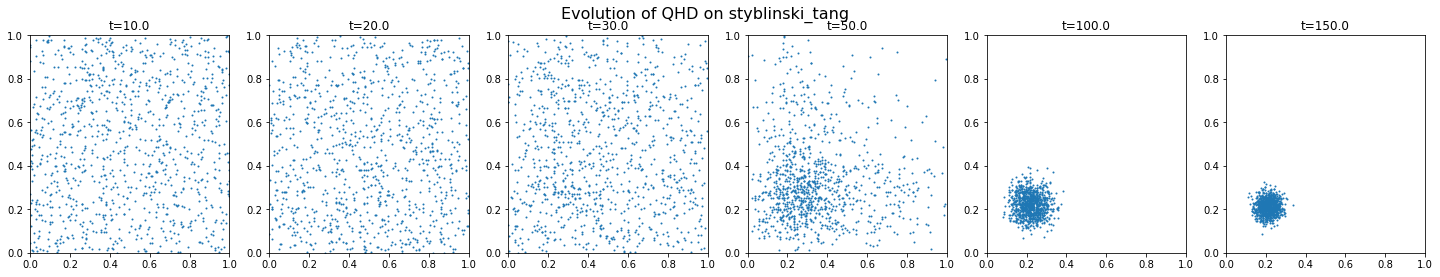

In [16]:
# QHD Plot
frames = [4, 8, 12, 20, 40, 60]
numruns = 1000 
n_plots = 6

fig, axs = plt.subplots(1, n_plots, figsize=(25,4))

fig.suptitle(f'Evolution of QHD on {instance}', fontsize=16)
for j in range(n_plots):
    frame = frames[j]
    snapshot_time = 2.5 * frame
    psi = np.load(os.path.join(QHD_WFN_DIR, wfn_files[frame]))
    qhd_prob = (psi * psi.conj()).real.flatten('F')
    samples = get_sample(qhd_coord_list, qhd_prob, numruns)
    axs[j].scatter(samples[:,0], samples[:,1],s=1)
    axs[j].set_xlim([0,1])
    axs[j].set_ylim([0,1])
    axs[j].set_title(f"t={snapshot_time}")
#plt.savefig('QHD.png')

In [18]:
# CHD Setup
CHD_DATA = {}
loadmat(join(DATA_DIR, f"{instance}_CHD.mat"), mdict=CHD_DATA)
chd_paths = CHD_DATA['positions']

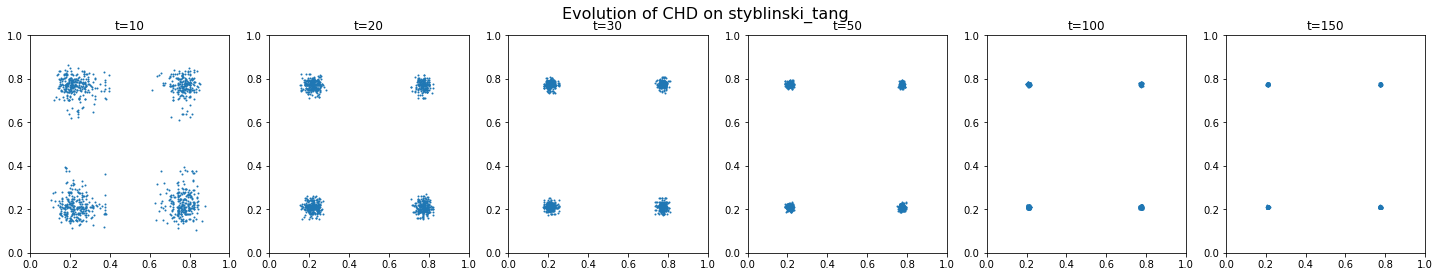

In [19]:
# CHD Plot
frames = np.array([10, 20, 30, 50, 100, 150]) - 2
numruns = 1000 
n_plots = 6

fig, axs = plt.subplots(1, n_plots, figsize=(25,4))

fig.suptitle(f'Evolution of CHD on {instance}', fontsize=16)
for j in range(n_plots):
    frame = frames[j]
    snapshot_time = frame + 2
    samples = np.zeros((numruns, 2))
    for k in range(numruns):
        samples[k,:] = chd_paths[k][0][frame]
    axs[j].scatter(samples[:,0], samples[:,1],s=1)
    axs[j].set_xlim([0,1])
    axs[j].set_ylim([0,1])
    axs[j].set_title(f"t={snapshot_time}")
#plt.savefig('CHD.png')

In [20]:
# SGD Setup
SGD_DATA = {}
loadmat(join(DATA_DIR, f"{instance}_NGD.mat"), mdict=SGD_DATA)
sgd_paths = SGD_DATA['ngd_positions']

def sgd_time(idx):
    alpha = 1e-2
    time = 0
    step_count = 0
    while step_count < idx:
        time += 1/(1 + alpha*step_count)
        step_count += 1
    return time

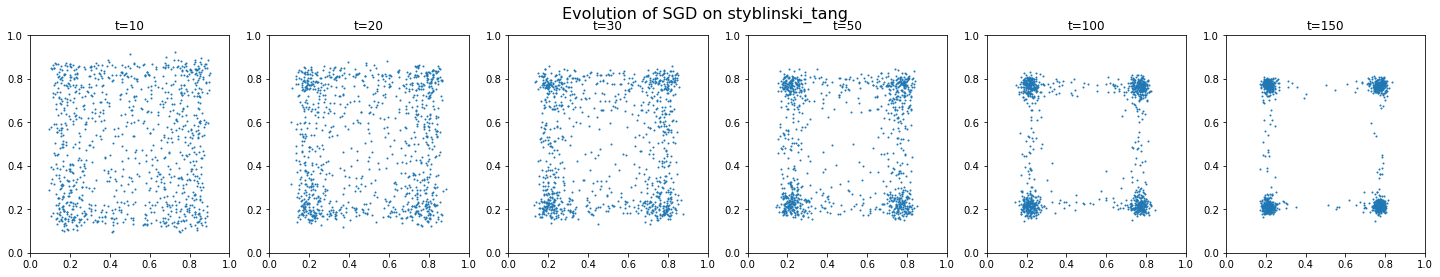

In [21]:
frames = [11, 22, 35, 65, 171, 346]
sgd_times = [10, 20, 30, 50, 100, 150]

fig, axs = plt.subplots(1, n_plots, figsize=(25,4))

fig.suptitle(f'Evolution of SGD on {instance}', fontsize=16)
for j in range(n_plots):
    frame = frames[j]
    snapshot_time = sgd_times[j]
    axs[j].scatter(sgd_paths[:,frame,0], sgd_paths[:,frame,1],s=1)
    axs[j].set_xlim([0,1])
    axs[j].set_ylim([0,1])
    axs[j].set_title(f"t={snapshot_time}")
#plt.savefig('SGD.png')

In [23]:
# QAA Setup
adb_steps = 64
dx = 1/(adb_steps+1)
adb_cells = np.linspace(dx, 1-dx, adb_steps)
qaa_coord_list = []

for i,j in product(adb_cells, adb_cells):
    qaa_coord_list.append([i,j])
    
QAA_DATA = {}
filepath = join(DATA_DIR, f"{instance}_QAA_T500.mat")
f = h5py.File(filepath)
for k, v in f.items():
    QAA_DATA[k] = np.array(v)

qaa_times = QAA_DATA["snapshot_times"][0]
qaa_wfn = QAA_DATA["wfn"].view(np.complex128)

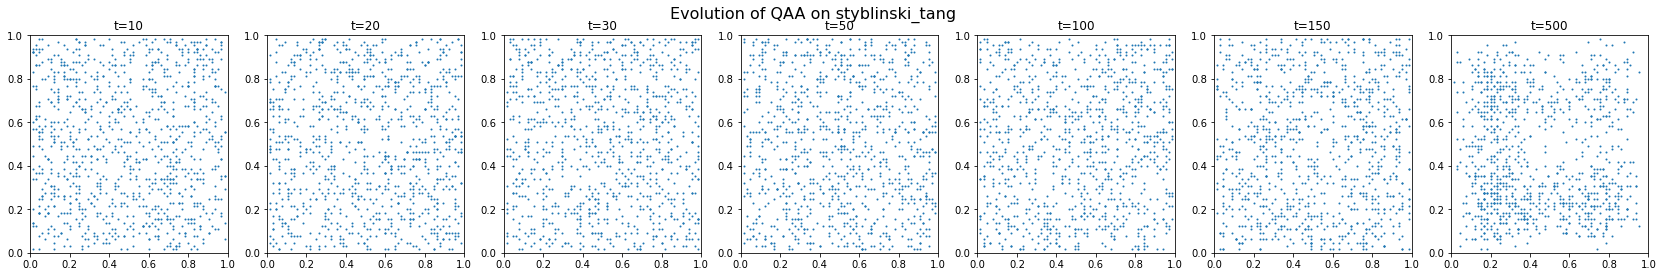

In [25]:
frames = [28, 55, 83, 138, 275, 413, -1]
qaa_disp_times = [10, 20, 30, 50, 100, 150, 500]

fig, axs = plt.subplots(1, n_plots+1, figsize=(29,4))

fig.suptitle(f'Evolution of QAA on {instance}', fontsize=16)
for j in range(n_plots+1):
    frame = frames[j]
    snapshot_time = qaa_disp_times[j]
    wfn_frame = qaa_wfn[:,frame]
    qaa_prob = (wfn_frame * np.conj(wfn_frame)).real
    samples = get_sample(qaa_coord_list, qaa_prob, numruns)
    axs[j].scatter(samples[:,0], samples[:,1],s=1)
    axs[j].set_xlim([0,1])
    axs[j].set_ylim([0,1])
    axs[j].set_title(f"t={snapshot_time}")
#plt.savefig('QAA.png')